
# Modeling



In [1]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from statsmodels.tsa.stattools import adfuller

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbpipline


## Read in master dataset and drop columns not needed for modeling

---

<p>The following columns are dropped:
    <ul>
        <li><b>Column : Reason</b></li>
        <li>Out Duration : Feature engineered total_duration</li>
        <li>Return Duration : Feature engineered total_duration</li>
        <li>timestamp : Not needed for modeling</li>
        <li>Out Time : Feature engineered dep_time</li>
        <li>Return Time : Feature engineered ret_time</li>
        <li>sort : Not needed for modeling</li>
        <li>Out Stop Cities : Layover cities not needed for modeling</li>
        <li>Return Stop Cities : Layover cities not needed for modeling</li>
        <li>Out Airline : Feature engineered dep_airline</li>
        <li>Return Airline : Feature engineered ret_airline</li>
        <li>Out Stops : Feature engineered total_stops</li>
        <li>Return Stops : Feature engineered total_stops</li>
    </ul>
This was done to reduce dimensionality and resolve any possible redundancies from the feature engineering</p>

In [2]:
df = pd.read_csv('data/masterdf.csv')
col_to_drop = ['Out Duration', 'Return Duration', 'timestamp', 'Out Time', 
                 'Return Time', 'sort', 'Out Stop Cities', 'Return Stop Cities',
                'Out Airline', 'Return Airline', 'Out Stops', 'Return Stops']
df = df.drop(col_to_drop, axis = 1)
df.head()

,Out Cities,Return Cities,Price,departure_date,total_duration,dep_time,ret_time,record_time,dep_airline,ret_airline,departure_day,search_day,total_stops,target
0,EWR‐SIN,SIN‐EWR,951,2022-04-10,3245,8:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0
1,EWR‐SIN,SIN‐EWR,979,2022-04-10,3185,9:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0
2,EWR‐SIN,SIN‐EWR,994,2022-04-10,2860,11:25,6:10,14,ANA,ANA,Sunday,Sunday,2,1
3,EWR‐SIN,SIN‐EWR,994,2022-04-10,3155,6:30,6:10,14,ANA,ANA,Sunday,Sunday,3,0
4,EWR‐SIN,SIN‐EWR,998,2022-04-10,3627,11:25,10:10,14,ANA,ANA,Sunday,Sunday,3,0



# Defining Functions for

<ol><b>
    <li>Modeling Pipelines</li>
    <li>Printing Scores and Confusion Matrix</li>
    <li>Returning GridSearch Optimized Parameters and Score</li>
    <li>Printing Results of DickeyFuller Test</li>
</b></ol>

---

In [3]:
# Function to fit model and print results from score_matrix_printer
def model_fit_print(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
    
    model.fit(X_train, y_train)
    score_matrix_printer(model, X_train, y_train, X_test, y_test)

def score_matrix_printer(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Cleaning up scores to be more visually appealing
    ascore_train = round((accuracy_score(y_train, train_pred) * 100), 2)
    pscore_train = round((precision_score(y_train, train_pred) * 100), 2)
    rscore_train = round((recall_score(y_train, train_pred) * 100), 2)
    
    ascore_test = round((accuracy_score(y_test, test_pred) * 100), 2)
    pscore_test = round((precision_score(y_test, test_pred) * 100), 2)
    rscore_test = round((recall_score(y_test, test_pred) * 100), 2)
    # Display confusion matrix
    conf_mat = plot_confusion_matrix(model, X_test, y_test)
    # Print Accuracy and Precision for both training and test in a structured format
    print(f"""
    Train Accuracy: {ascore_train}%
    Train Precision: {pscore_train}%
    ==============================
    Test Accuracy: {ascore_test}%
    Test Precision: {pscore_test}%
    """)

In [4]:
# Function to print results from GridSearch in a structured format
def grid_result(grid_model):
    print(f"""
    Optimized score and Parameters
    ==============================
    Score: {grid_model.best_score_}
    ==============================
    Parameters: {grid_model.best_params_}
    """)

In [5]:
# importing relevant library
from statsmodels.tsa.stattools import adfuller

# For testing stationarity
def dicky_fuller(ts):
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(
                    dftest[0:4], 
                    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    alpha = 0.05
    is_stationary = dftest[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(dftest[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(dftest[1],3)}')
        
    display(dfoutput)

In [6]:
X = df.drop('target', axis=1)
y = df['target']

In [7]:
# numeric_features = X.select_dtypes(exclude="object")
# numeric_features
# ss = StandardScaler()
# num_df = pd.DataFrame(ss.fit_transform(numeric_features),
#                      columns = numeric_features.columns,
#                      index = numeric_features.index)
# num_df.head()


# Instantiating Column Transformer for Pipelines

---

Here I am creating the process for One Hot Encoding my categorical variables and scaling the numeric variables

In [9]:
# ColumnTransformer to handle numerics and categoricals for pipelines
numeric_features = X.select_dtypes(exclude="object").columns
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = X.select_dtypes(include="object").columns
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [10]:
from sklearn.dummy import DummyClassifier

In [11]:
def num_encoder(df_to_encode):
    ss = StandardScaler()

    ss.fit(df_to_encode)
    nums_df = pd.DataFrame(ss.transform(df_to_encode),
                           columns = df_to_encode.columns,
                          index = df_to_encode.index)
    return nums_df

def cat_encoder(df_to_encode):
    ohe = OneHotEncoder(
        drop = 'first',
        sparse = False)
    
    cats = ohe.fit_transform(df_to_encode)
    cat_df = pd.DataFrame(cats,
                            columns = ohe.get_feature_names(),
                            index = df_to_encode.index)
    return cat_df

def split_join(split):
    categories = split.select_dtypes('object')
    numerics = split.select_dtypes(['float64', 'int64'])

    joined = pd.concat([num_encoder(numerics), cat_encoder(categories)], axis = 1)
    return joined

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
X_train_clean = split_join(X_train)
X_test_clean = split_join(X_test)


# Baseline Model

---

Dummy Classifier was used for the Baseline Model<br>
    Producing a score of <b>51%</b>

In [13]:
# Baseline model
baseline = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ("dummy", DummyClassifier(strategy= 'uniform', random_state=32))
])

baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)

0.5077105575326216


# Model One Logistic Regression Model

---

<p>For the first model I chose a Logistic Regression Model<br>
    This was done to see how it would preform before conducting any oversampling<br>
    We see that it has a
    <ul>
        <li><b>Accuracy Score of 99.41%</b></li>
        <li><b>Precision Score of 91.59%</b></li>
    </ul>
It may seem good, but knowing that I need to address the class imbalance present in my data means that this is not an accurate representation of my model's performance</p>


    Train Accuracy: 99.64%
    Train Precision: 95.99%
    ------------------------------
    Test Accuracy: 99.41%
    Test Precision: 91.59%
    


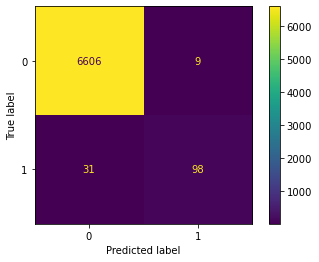

In [14]:
# Logistic Regression model
logreg_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression(max_iter = 1000, random_state=32)) # max_iter called to resolve warning
])

model_fit_print(logreg_model, X, y)

In [37]:
df['target'].value_counts(normalize=True) # To show class imbalance

0    0.980611
1    0.019389
Name: target, dtype: float64


## After oversampling to deal with class imbalance

We see that 
<ul>
    <li><b>Accuracy Score decreased to 98.55%</b></li>
    <li><b>Precision Score decreased to 56.95%</b></li>
</ul>
This is still an improvement from our baseline model, but the precision is not ideal


    Train Accuracy: 98.86%
    Train Precision: 63.14%
    ------------------------------
    Test Accuracy: 98.55%
    Test Precision: 56.95%
    


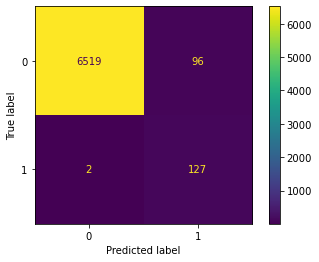

In [16]:
model_1 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("logreg", LogisticRegression(max_iter = 1000, random_state=32)) # max_iter called to resolve warning
])

model_fit_print(model_1, X, y)


# Model Two Decision Tree Classifier

---

<p>The next model I decided to use was a Decison Tree Classifier to improve the precision score
    For the first iteration I did not declare any stop parameters
    As expected the model is severly overfit producing a
<ul>
    <li><b>Training Accuracy Score of 100%</b></li>
    <li><b>Training Precision Score of 100%</b></li>
    ============And============
    <li><b>Testing Accuracy Score of 99.54%</b></li>
    <li><b>Testing Precision Score of 88.89%</b></li>
</ul>
    


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    ------------------------------
    Test Accuracy: 99.54%
    Test Precision: 88.89%
    


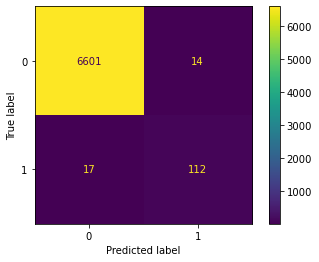

In [17]:
dtree_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("dtree", DecisionTreeClassifier(random_state=32))
])

model_fit_print(dtree_model, X, y)


## Finding Optimal Parameters with GridSearch

<p>To address the overfitting and in addition find the optimal parameters for the Decision Tree Classifier I implemented Grid Seach with the following parameters:<br>
<code>"criterion":['gini', 'entropy'],
"max_depth":[1, 10, 25, 50],
"min_samples_split":range(1, 10),
"min_samples_leaf":range(1, 10)</code><br>
==========================================<br>
After running the GridSearch it return the following as optimal parameters:<br>
<code>criterion= 'entropy'
max_depth= 10 
min_samples_split= 3
min_samples_leaf= 1</code><p>

In [18]:
# # Approximately 1 minute run time
# param_dict = {
#     "dtree__criterion":['gini', 'entropy'],
#     "dtree__max_depth":[1, 10, 25, 50],
#     "dtree__min_samples_split":range(1, 10),
#     "dtree__min_samples_leaf":range(1, 10)
# }

# gs = GridSearchCV(estimator=dtree_model,
#                  param_grid=param_dict,
#                  cv=5,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)


## After running with the optimal parameters

We see that 
<ul>
    <li><b>Training Accuracy Score decreased to 99.79%</b></li>
    <li><b>Training Precision Score decreased to 90.91%</b></li>
    ============And============
    <li><b>Testing Accuracy Score increased to 99.79%</b></li>
    <li><b>Testing Precision Score increased to 91.37%</b></li>
</ul>
These scores are extremely good and the overfitting has been resolved!


    Train Accuracy: 99.79%
    Train Precision: 90.91%
    ------------------------------
    Test Accuracy: 99.79%
    Test Precision: 91.37%
    


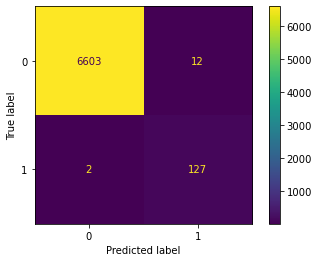

In [19]:
dtree_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("dtree", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, min_samples_split= 3,
                                    min_samples_leaf= 1, random_state= 32))
])

model_fit_print(dtree_model2, X, y)


    Train Accuracy: 96.34%
    Train Precision: 34.74%
    ------------------------------
    Test Accuracy: 94.71%
    Test Precision: 23.49%
    


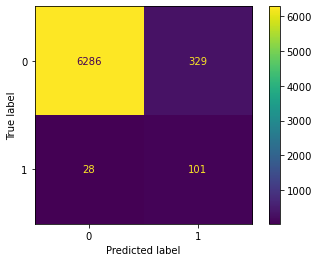

In [20]:
knn_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("knn", KNeighborsClassifier())
])

model_fit_print(knn_model, X, y)

In [21]:
# # Approximately 4 minute run time
# param_dict = {
#     'knn__n_neighbors': range(5, 30),
#     'knn__metric': ['manhattan', 'minkowski', 'euclidean'],
#     'knn__weights' : ['distance', 'uniform']
# }

# gs = GridSearchCV(estimator=knn_model,
#                  param_grid=param_dict,
#                  cv=5,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    ------------------------------
    Test Accuracy: 97.88%
    Test Precision: 46.32%
    


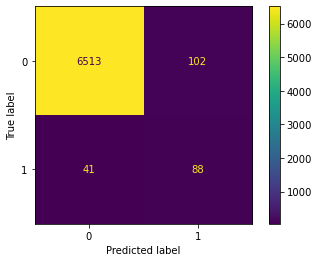

In [22]:
knn_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("knn", KNeighborsClassifier(n_neighbors= 5, metric= 'manhattan', weights= 'distance'))
])

model_fit_print(knn_model2, X, y)

In [ ]:
rforest_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("rf", RandomForestClassifier(random_state = 32))
])

model_fit_print(rforest_model, X, y)

In [ ]:
# # Approximately 15 minute run time
# rforest_grid = imbpipline(steps=[
#     ("preprocessor", preprocessor),
#     ('SMOTE', SMOTE(random_state = 32)),
#     ("rf", RandomForestClassifier(random_state = 32))
# ])

# param_grid = {
#     "rf__n_estimators":[30, 100, 150, 200],
#     "rf__criterion":['gini', 'entropy'], 
#     "rf__max_depth":[1, 10, 25, 50],
#     "rf__min_samples_split":range(1, 10),
#     "rf__min_samples_leaf":range(1, 10)
# }            

# gs = GridSearchCV(estimator=rforest_grid,
#                  param_grid=param_grid,
#                  cv=5,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)

In [ ]:
rforest_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("rf", RandomForestClassifier(criterion = 'entropy', n_estimators = 100, max_depth = 50,
                                  min_samples_leaf = 2, min_samples_split = 5, random_state = 32))
])

model_fit_print(rforest_model2, X, y)

In [23]:
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.metrics import calinski_harabasz_score

1658.0037480490319


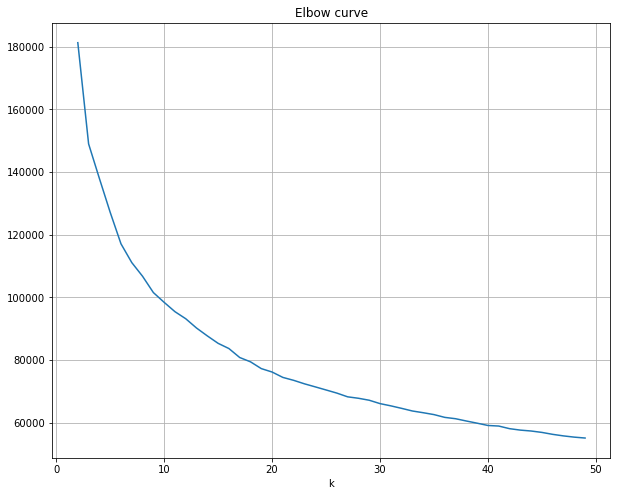

In [24]:
distortions = []

# Calculate SSE for different K
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=32)
    kmeans.fit(X_train_clean) 
    distortions.append(kmeans.inertia_)

# Plot values of SSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Elbow curve')
ax.set_xlabel('k')
ax.plot(range(2, 10), distortions)
ax.grid(True)

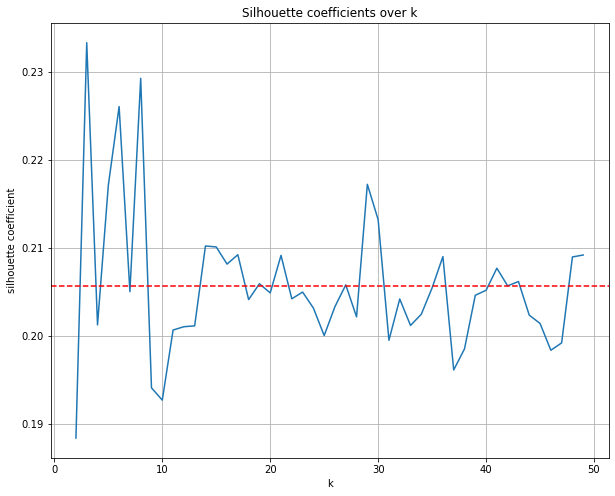

In [26]:
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X_train_clean)
    silhouette_avg = metrics.silhouette_score(X_train_clean, cluster_labels)
    silhouette_plot.append(silhouette_avg)

# Plot Silhouette coefficient
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Silhouette coefficients over k')
ax.set_xlabel('k')
ax.set_ylabel('silhouette coefficient')
ax.plot(range(2, 10), silhouette_plot)
ax.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
ax.grid(True)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=32)

kmeans.fit(X_train_clean) 

cluster_assignments = kmeans.predict(X_test_clean)

print(calinski_harabasz_score(X_test_clean, cluster_assignments)) #higher score better


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    ------------------------------
    Test Accuracy: 99.9%
    Test Precision: 100.0%
    


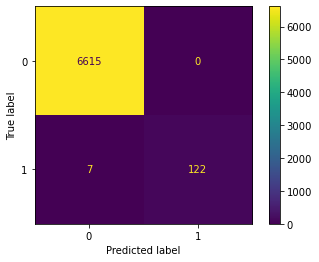


    Train Accuracy: 99.97%
    Train Precision: 100.0%
    ------------------------------
    Test Accuracy: 99.9%
    Test Precision: 100.0%
    


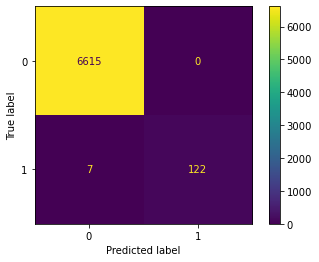

In [31]:
from sklearn.ensemble import VotingClassifier

The data is stationary with a fuller score of 0.0


Test Statistic                -8.961229e+00
p-value                        8.214079e-15
#Lags Used                     4.900000e+01
Number of Observations Used    2.692400e+04
Critical Value (1%)           -3.430593e+00
Critical Value (5%)           -2.861647e+00
Critical Value (10%)          -2.566827e+00
dtype: float64

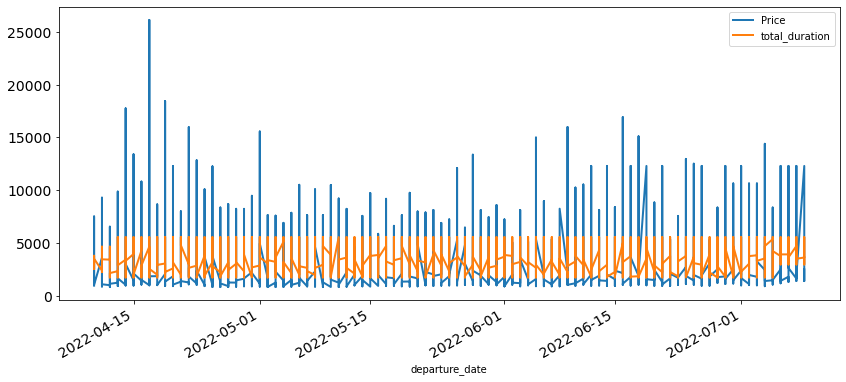

In [32]:
time_df = df.set_index(pd.to_datetime(df['departure_date']), drop=True)
ts = time_df['Price']
time_df = time_df.filter(['Price', 'total_duration'], axis=1)

time_df.plot(figsize=(14,6), linewidth=2, fontsize=14);
dicky_fuller(ts)

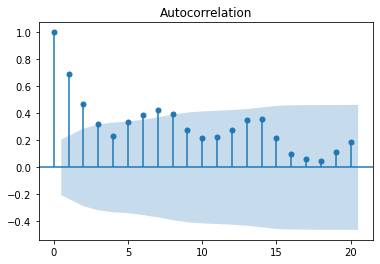

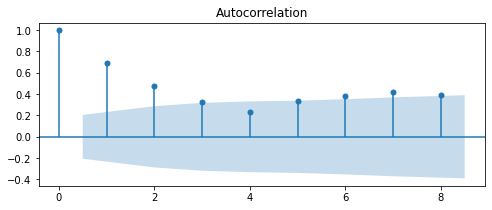

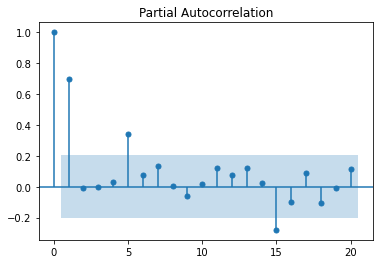

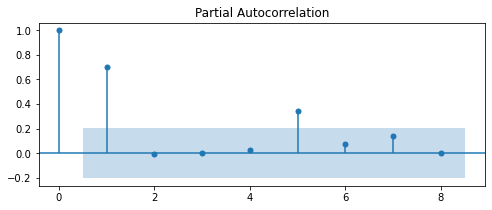

In [33]:
ts_daily = ts.resample('D').mean()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(ts_daily)

fig, ax = plt.subplots(figsize=(8,3))
plot_acf(ts_daily, ax=ax, lags=8);

plot_pacf(ts_daily) #shown below is that an AR term of 1 is ideal

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(ts_daily, ax=ax, lags=8);

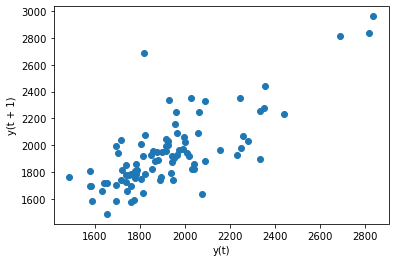

In [34]:
from pandas.plotting import lag_plot
lag_plot(ts_daily)
plt.show()

In [35]:
# from statsmodels.tsa.arima_model import ARIMA
# model = ARIMA(ts_daily, order=(1, 0, 1)) 
# results_ARIMA = model.fit()

import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(ts_daily, order=(1,0,2)).fit()
# result = model.
model.summary()

C:\Users\Jun\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                   91
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -600.028
Date:                Thu, 07 Apr 2022   AIC                           1210.056
Time:                        12:56:29   BIC                           1222.610
Sample:                    04-10-2022   HQIC                          1215.121
                         - 07-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2096.2187    342.557      6.119      0.000    1424.819    2767.618
ar.L1          0.9825      0.039     25.462      0.000       0.907       1.058
ma.L1         -0.3195      0.095     -3.375      0.001      -0.505      -0.134
ma.L2         -0.3074      0.113     -2.730      0.006      -0.528      -0.087
sigma2       3.06e+04   3868.214      7.910      0.000     2.3e+04    3.82e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                17.49
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.65
Prob(H) (two-sided):                  0.17   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""